# Bedrock AgentCore Memory Store Walkthrough - Long Term Memory

This sample notebook walks through setup and usage of the Bedrock AgentCore Memory Store with LangGraph. This approach enables saving of conversations to the AgentCore memory API to be later extracted and retrieved, enabling long term memory.

### Setup
For this notebook you will need:
1. An Amazon Web Services development account
2. Bedrock Model Access (i.e. Claude 3.7 Sonnet)
3. An AgentCore Memory Resource configured (see below section for details)
4. Two strategies enabled for the Agent Core Memory resource, `/facts/{actor_id}` semantic search and `/preferences/{actor_id}` user preference search

### AgentCore Memory Resource

Either in the AWS developer portal or using the boto3 library you must create an [AgentCore Memory Resource](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agentcore-control/client/create_memory.html). For this notebook, only two strategies need to be enabled, user preferences and semantic memory. These strategies will automatically run once we save our conversational messages to AgentCore Memory and extract chunks of information that our agent can retrieve later. For more information on long term memory, see the docs here [AgentCore Long Term Memory](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/long-term-memory.html).

Once you have the Memory enabled and in a `ACTIVE` state, take note of the `memoryId` and strategy namespaces, we will need them later.

In [ ]:
%pip install langchain langchain-aws

In [ ]:
# Import LangGraph and LangChain components
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
import uuid
import logging
logging.getLogger().setLevel(logging.DEBUG)

from langgraph.utils.config import get_store

In [ ]:
# Import the AgentCoreMemoryStore that we will use as a store
from langgraph_checkpoint_aws import AgentCoreMemoryStore

# For this example, we will just use an InMemorySaver to save context.
# In production, we highly recommend the AgentCoreMemorySaver as a checkpointer
# which works seamlessly alongside the memory store
from langgraph.checkpoint.memory import InMemorySaver

## AgentCore Memory Configuration
- `REGION` corresponds to the AWS region that your resources are present in, these are passed to the `AgentCoreMemorySaver`.
- `MEMORY_ID` corresponds to your top level AgentCore Memory resource. Within this resource we will store checkpoints for multiple actors and sessions
- `MODEL_ID` this is the bedrock model that will power our LangGraph agent through Bedrock Converse.

We will use the `MEMORY_ID` and any additional boto3 client keyword args (in our case, `REGION`) to instantiate our checkpointer.

In [39]:
REGION = "us-west-2"
MEMORY_ID = "YOUR_MEMORY_ID"
MODEL_ID = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"

# Initialize the store to enable long term memory saving and retrieval
store = AgentCoreMemoryStore(memory_id=MEMORY_ID, region_name=REGION)

# Initialize Bedrock LLM
llm = init_chat_model(MODEL_ID, model_provider="bedrock_converse", region_name=REGION)

### Define our long term memory retrieval tools

In LangChain, tools can be injected at runtime with a Store argument [InjectedStore](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.tool_node.InjectedStore) to ensure that we can dynamically use the store to access different namespaces. In our case, this means we can pass the `actor_id` to the tool through the `config` (`RunnableConfig`). This is filled in when the tool is called so the tool can only access that actor_id's memories. 

The tool will search the namespace we specify, in this case the `/facts/{actor_id}` namespace which is a semantic memory namespace we specified above (at the top of the notebook). As the memories are extracted over time, these will be available to the agent through this tool.

In [6]:
@tool
def retrieve_user_facts_from_past_conversations(
    query: str,
    config: RunnableConfig,
    limit: int = 3,
) -> str:
    """Retrieve facts about the user that might be helfpul in answering vague questions"""
    
    # Actor ID comes from the runtime config we specify when invoking the agent
    actor_id = config["configurable"]["actor_id"]

    # Namespace we defined, where semantic facts are extracted for the user across
    # sessions. This is combined under the hood with `/` to match AgentCore namespaces
    search_namespace = ("facts", actor_id)

    store = get_store()
    
    result = store.search(search_namespace, query=query, limit=limit)
    return result

tools = [retrieve_user_facts_from_past_conversations]

### Storing the messages that we want for long term memory extraction

In Bedrock AgentCore, each conversational message that is added for an `actor_id` and `session_id` is processed in the service according to the strategies specified for that memory resource. In our case, since we defined two strategies, user preference and semantic extraction, both user preferences and facts from previous conversations will be stored as long term memories in the service that can be retrieved by our retrieval tool above.

For this example, we will use the AgentCoreMemoryStore to save messages in the pre and post model hooks so that we capture both the HumanMessage objects and the AIMessage objects that occur during the conversation. The pre-model hook runs before the LLM invocation and the post-model hook runs after it to capture the response from the agent.

The pre-model hook will also perform a semantic search using the user's latest message to add a few relevant results to the LLMs input so it can have context into the users past preferences. If needed, the LLM can also search itself using the semantic search tool.

**Note**: LangChain message types are converted under the hood by the store to AgentCore Memory message types so that they can be properly extracted to long term memories.

In [32]:
def pre_model_hook(state, config: RunnableConfig, *, store: BaseStore):
    """Hook that runs pre-LLM invocation to save the latest human message"""
    actor_id = config["configurable"]["actor_id"]
    thread_id = config["configurable"]["thread_id"]
    # Saving the message to the actor and session combination that we get at runtime
    namespace = (actor_id, thread_id)
    
    messages = state.get("messages", [])
    # Save the last human message we see before LLM invocation
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            store.put(namespace, str(uuid.uuid4()), {"message": msg})
            break
    # Retrieve user preferences based on the last message and append to state
    user_preferences_namespace = ("preferences", actor_id)
    preferences = store.search(user_preferences_namespace, query=msg.content, limit=5)
    
    # Construct another AI message to add context before the current message
    if preferences:
        context_items = [pref.value for pref in preferences]
        context_message = AIMessage(
            content=f"[User Context: {', '.join(str(item) for item in context_items)}]"
        )
        # Insert the context message before the last human message
        return {"messages": messages[:-1] + [context_message, messages[-1]]}
    
    return {"llm_input_messages": messages}

def post_model_hook(state, config: RunnableConfig, *, store: BaseStore):
    """Hook that runs post-LLM invocation to save the latest human message"""
    actor_id = config["configurable"]["actor_id"]
    thread_id = config["configurable"]["thread_id"]

    # Saving the message to the actor and session combination that we get at runtime
    namespace = (actor_id, thread_id)
    
    messages = state.get("messages", [])
    # Save the LLMs response to AgentCore Memory
    for msg in reversed(messages):
        if isinstance(msg, AIMessage):
            store.put(namespace, str(uuid.uuid4()), {"message": msg})
            break
    
    return {"messages": messages}

## Build our LangGraph agent graph

Our agent will be built with the `create_react_agent` builder. It just has a few simple nodes, mainly a chatbot node and a tool node. The tool node will contain just our long term memory retrieval tool and the pre and post model hooks are specified as arguments.

**Note**: for custom agent implementations the Store and tools can be configured to run as needed for any workflow following this pattern. Pre/post model hooks can be used, the whole conversation could be saved at the end, etc.

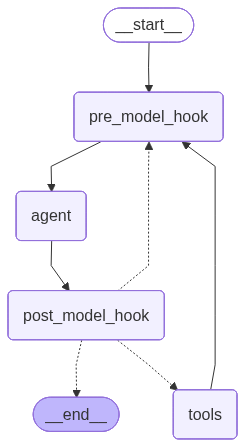

In [33]:
graph = create_react_agent(
    llm, 
    tools=tools,
    store=store,
    checkpointer=InMemorySaver(),
    pre_model_hook=pre_model_hook,
    post_model_hook=post_model_hook
)

graph

## IMPORTANT: Input and Config

### Graph Invoke Input
We only need to pass the newest user message in as an argument `inputs`. This could include other state variables too but for the simple `create_react_agent`, messages are all that's required.

### LangGraph RuntimeConfig
In LangGraph, config is a `RuntimeConfig` that contains attributes that are necessary at invocation time, for example user IDs or session IDs. For the `AgentCoreMemorySaver`, `thread_id` and `actor_id` must be set in the config. For instance, your AgentCore invocation endpoint could assign this based on the identity or user ID of the caller. Additional documentation here: [https://langchain-ai.github.io/langgraphjs/how-tos/configuration/](https://langchain-ai.github.io/langgraphjs/how-tos/configuration/)



In [35]:
config = {
    "configurable": {
        "thread_id": "session-1", # REQUIRED: This maps to Bedrock AgentCore session_id under the hood
        "actor_id": "user-1", # REQUIRED: This maps to Bedrock AgentCore actor_id under the hood
    }
}

### Run the Agent

For this example, we will run through a conversation where the user is talking about what they like to cook with. This will give the backend enough context to extract facts and user preferences that we can retrieve the next time the user asks for what to make on a given evening.

In [36]:
# Helper function to pretty print agent output while running
def run_agent(query: str, config: RunnableConfig):
    printed_ids = set()
    events = graph.stream(
        {"messages": [{"role": "user", "content": query}]},
        config,
        stream_mode="values",
    )
    for event in events:
        if "messages" in event:
            for msg in event["messages"]:
                # Check if we've already printed this message
                if id(msg) not in printed_ids:
                    msg.pretty_print()
                    printed_ids.add(id(msg))


prompt = """
Hey there! Im cooking one of my favorite meals tonight, salmon with rice and veggies (healthy). Has
great macros for my weightlifting competition that is coming up. What can I add to this dish to make it taste better
and also improve the protein and vitamins I get?
"""

run_agent(prompt, config)

================================ Human Message =================================


Hey there! Im cooking one of my favorite meals tonight, salmon with rice and veggies (healthy). Has
great macros for my weightlifting competition that is coming up. What can I add to this dish to make it taste better
and also improve the protein and vitamins I get?

================================== Ai Message ==================================

[{'type': 'text', 'text': "I'd be happy to help you enhance your salmon dish for your upcoming weightlifting competition! Let me see if I have some additional information about your dietary preferences or nutritional goals from our past conversations that might help me give more personalized suggestions."}, {'type': 'tool_use', 'name': 'retrieve_user_facts_from_past_conversations', 'input': {'query': 'dietary preferences weightlifting nutrition protein requirements supplements'}, 'id': 'tooluse_rjCYWu9BS_SleO9B7iRJUg'}]
Tool Calls:
  retrieve_user_facts_from_pas

### What was stored?
As you can see, the model does not yet have any insight into our preferences or dietary restrictions.

For this implementation with pre/post model hooks, two messages were stored here. The first message from the user and the response from the AI model were both stored as conversational events in AgentCore Memory.

These messages were then extracted to AgentCore long term memory in our fact and user preferences namespaces. In fact, we can check the store ourselves to verify what has been stored there so far:

In [37]:
# Search our facts namespace (the one that is used by the agent long term retrieval)
search_namespace = ("facts", "user-1")
result = store.search(search_namespace, query="food", limit=3)
print(f"Facts namespace result: {result}\n")

# Search our user preferences namespace
search_namespace = ("preferences", "user-1")
result = store.search(search_namespace, query="food", limit=3)
print(f"Preferences namespace result: {result}")

Facts namespace result: [Item(namespace=['facts', 'user-1'], key='mem-596ad8e5-f561-4bea-861a-c498276e92f8', value={'content': 'The user is preparing for a weightlifting competition and is cooking a healthy meal of salmon, rice, and vegetables.', 'memory_strategy_id': 'memory_semantic_ghc4p-SLjZ3l87ji', 'namespaces': ['/facts/user-1']}, created_at='2025-09-24T17:55:09-07:00', updated_at='2025-09-24T17:55:09-07:00', score=0.40105253), Item(namespace=['facts', 'user-1'], key='mem-c040719d-81a4-41eb-9b8a-6d4848d75dcf', value={'content': 'The user is focused on maintaining good macronutrient balance in their diet to support their weightlifting training.', 'memory_strategy_id': 'memory_semantic_ghc4p-SLjZ3l87ji', 'namespaces': ['/facts/user-1']}, created_at='2025-09-24T17:55:09-07:00', updated_at='2025-09-24T17:55:09-07:00', score=0.37003443)]

Preferences namespace result: [Item(namespace=['preferences', 'user-1'], key='mem-52e75280-1c1c-41aa-874b-e4725dba60bc', value={'content': '{"contex

### Agent access to the store

Great! Now we have seen that long term memories were extracted to our namespaces based on the earlier messages in the conversation.

Now, let's start a new session and ask about recommendations for what to cook for dinner. The agent can use the store to access the long term memories that were extracted to make a recommendation that the user will be sure to like.

In [38]:
config = {
    "configurable": {
        "thread_id": "session-2", # New session ID
        "actor_id": "user-1", # Same actor ID
    }
}

run_agent("Today's a new day, what should I make for dinner tonight?", config)

================================ Human Message =================================

Today's a new day, what should I make for dinner tonight?
================================== Ai Message ==================================

[User Context: {'content': '{"context":"User is preparing for a weightlifting competition and is concerned about meal\'s nutritional value","preference":"Interested in meals that support athletic performance and nutrition","categories":["fitness","nutrition","sports"]}', 'memory_strategy_id': 'memory_preference_ghc4p-zjtCX1D9Eo', 'namespaces': ['/preferences/user-1']}, {'content': '{"context":"User mentioned cooking salmon with rice and vegetables, indicating a focus on healthy eating for a weightlifting competition","preference":"Follows a health-conscious diet with high-protein, nutritious meals","categories":["food","nutrition","fitness","diet"]}', 'memory_strategy_id': 'memory_preference_ghc4p-zjtCX1D9Eo', 'namespaces': ['/preferences/user-1']}]
==================

### Wrapping up

As you can see, the agent received both pre-model hook context from the user preferences namespace search and was able to search on its own for long term memories in the fact namespace to create a comprehensive answer for the user.

The AgentCoreMemoryStore is very flexible and can be implemented in a variety of ways, including pre/post model hooks or just tools themselves with store operations. Used alongside the AgentCoreMemorySaver for checkpointing, both full conversational state and long term insights can be combined to form a complex and intelligent agent system.